# S2D Conference

# Tutorial: The CASTOR Grism Simulator & Exposure Time Calculator
## Gaël Noirot - May 17, 2023
## Notebook created with ETC_grism_dev 0.4.0.

# Goal 1: Get the SNR per resolution element of a source observed with the CASTOR UV and U slitless grisms.

# 0 - imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import ETC_grism_dev
from ETC_grism_dev import background
from ETC_grism_dev import spectrum
from ETC_grism_dev import disperser
from ETC_grism_dev import utils

# 1 - Build/import the source direct image and associated segmentation map.
# Example A: Create the direct image source using a Sersic2D profile.

In [2]:
#Use a sersic profile
from astropy.modeling.models import Sersic2D
pix_scale = 0.1 #CASTOR telescope pixel scale in arcsec
source_eff_radius_arcsec = 3/7.5 #arcsec
source_eff_radius_pixels = source_eff_radius_arcsec/pix_scale
box_size = source_eff_radius_pixels * 4

x,y = np.meshgrid(np.arange(box_size), np.arange(box_size))

sersic_model = Sersic2D(amplitude = 1, r_eff = source_eff_radius_pixels, n=1, x_0=box_size/2, y_0=box_size/2,
               ellip=.35, theta=-1)
source_image_a = sersic_model(x, y)

#source segmentation region (boolean)
#"True" pixels will be dispersed, while "False" will be ignored
source_seg_a = source_image_a/np.max(source_image_a) > 1e-2



/var/folders/x4/732lcbsj15v9fwvrd_hmx_jr0000gn/T/ipykernel_33802/3956480238.py:9: MatplotlibDeprecationWarning: 
The 'update_ticks' parameter of set_ticks() was deprecated in Matplotlib 3.5 and will be removed two minor releases later. If any parameter follows 'update_ticks', they should be passed as keyword, not positionally.
  cbar.set_ticks([-1, 0, 1], update_ticks=True)


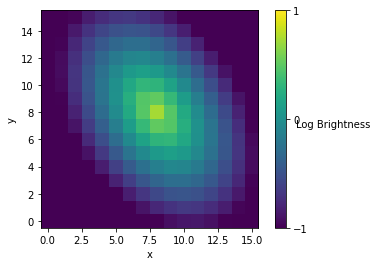

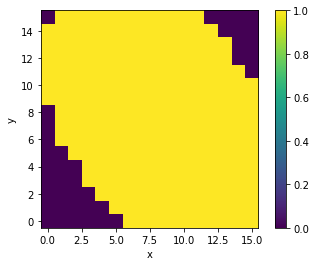

In [3]:
#view source
plt.figure()
plt.imshow(np.log10(source_image_a), origin='lower', interpolation='none',
           vmin=-1, vmax=1)
plt.xlabel('x')
plt.ylabel('y')
cbar = plt.colorbar()
cbar.set_label('Log Brightness', rotation=0, labelpad=25)
cbar.set_ticks([-1, 0, 1], update_ticks=True)

#view seg region
plt.figure()
plt.imshow(source_seg_a, origin='lower', interpolation='none', vmin=0, vmax=1)
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# 1. Example B: Load existing direct image/seg map from a file.

In [4]:
# direct image
source_image_b = np.load('./data/175_image.npy', allow_pickle=True)

# segmentation
source_seg_b = source_image_b/np.max(source_image_b) > 1e-2

/var/folders/x4/732lcbsj15v9fwvrd_hmx_jr0000gn/T/ipykernel_33802/1096568451.py:9: MatplotlibDeprecationWarning: 
The 'update_ticks' parameter of set_ticks() was deprecated in Matplotlib 3.5 and will be removed two minor releases later. If any parameter follows 'update_ticks', they should be passed as keyword, not positionally.
  cbar.set_ticks([-1, 0, 1], update_ticks=True)


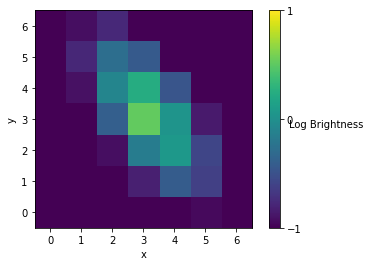

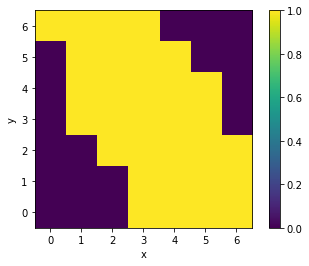

In [5]:
#view source
plt.figure()
plt.imshow(np.log10(source_image_b), origin='lower', interpolation='none',
           vmin=-1, vmax=1)
plt.xlabel('x')
plt.ylabel('y')
cbar = plt.colorbar()
cbar.set_label('Log Brightness', rotation=0, labelpad=25)
cbar.set_ticks([-1, 0, 1], update_ticks=True)

#view seg region
plt.figure()
plt.imshow(source_seg_b, origin='lower', interpolation='none', vmin=0, vmax=1)
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# 2 - The associated source spectrum
# Example A: Create the source spectrum using FSPS.

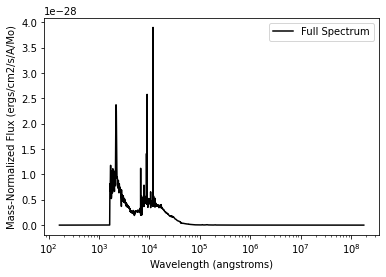

0

In [6]:
#Here we generate an FSPS spectrum.
#The user can also generate its own spectrum that can be then passed to the spectrum object with:
#spectrum.spectrum = (wave, flux)
#where 'wave' is the 1D wavelength array in angstroms, and 'flux' is the 1D flux array in ergs/cm2/s/A.

#If running FSPS for the first time, this might take a little bit of time.
source_redshift = 0.8 #If a redshift other than 0 is provided, then spectrum is automatically redshifted.
fsps_params_dict = {"tau": 1, "logzsol": 0, "dust2": 0.2}
fsps_age = 5 #Gyrs

spectrum.spectrum_from_fsps(spectrum, fsps_params_dict=fsps_params_dict, fsps_age=fsps_age, redshift=source_redshift, check=True)


In [7]:
spectrum_a = spectrum.spectrum


# 2. Example B: Get the source spectrum from file.

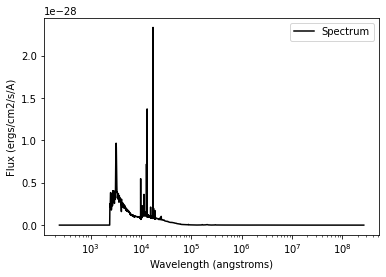

0

In [8]:
#Here we use a source spectrum from file.
#It assumes that wavelengths are in angstroms and fluxes in ergs/cm2/s/A
#The user can provide their own spectrum/file has long as they are in the same format as the example files in 'files/spectra/'.
#The user can also generate an FSPS spectrum using the tool (see the 'grism_etc_example.ipynb' notebook).
#The user can also generate its own spectrum that can be then passed to the spectrum object with:
#spectrum.spectrum = (wave, flux)
#where 'wave' is the 1D wavelength array in angstroms, and 'flux' is the 1D flux array in ergs/cm2/s/A.

#path_to_file = utils.ETC_GRISM_HOME+'files/spectra/fsps_quiescent.txt' #quiescent galaxy spectrum
path_to_file = utils.ETC_GRISM_HOME+'files/spectra/fsps_star_forming.txt' #star forming galaxy spectrum with: "tau": 2, "logzsol": 0, "dust2": 0.4, "age": 4
wave_key = 'wavelength' #wavelength keyword
flux_key = 'flux' #flux keyword
redshift = 1.65 #if a redshift > 0 is provided, the file spectrum will be redshifted to that redshift.

spectrum.spectrum_from_file(spectrum, path_to_file, wave_key, flux_key, redshift=redshift, check=True)


In [9]:
spectrum_b = spectrum.spectrum


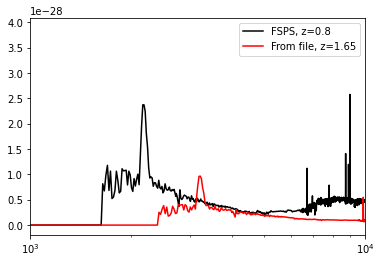

In [10]:
#compare
plt.figure()
plt.plot(spectrum_a[0], spectrum_a[1], 'k-', label='FSPS, z=0.8')
plt.plot(spectrum_b[0], spectrum_b[1], 'r-', label='From file, z=1.65')
plt.xlim(1000, 10000)
plt.xscale('log')
plt.legend()


# 2. Normalize the spectrum to a given CASTOR band 

TARGET_FLAM, NON_NORM_FLAM, SCALING:  3.5352987765083095e-17 9.0479977259673e-29 390727195516.6588
NORM_FLAM, NORM_FNU, NORM_MAG:  3.535298776508309e-17 5.754399373371588 21.999999999999993
TARGET_FLAM, TARGET_FNU, TARGET_MAG:  3.5352987765083095e-17 5.75439937337159 22


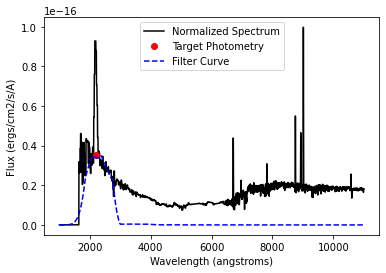

0

In [11]:
#Normalize spectrum to a given mag in one of the CASTOR filters (uv, u or g).

#spectrum A, UV = 22 AB mag
spectrum.spectrum = spectrum_a

source_mag = 22
filter_channel = "uv"
spectrum.normalize_spectrum(spectrum, magnitude=source_mag, filter_channel=filter_channel, check=True)



In [12]:
#normalized spectrum A
spectrum_a_norm = spectrum.spectrum

TARGET_FLAM, NON_NORM_FLAM, SCALING:  9.27170019705939e-18 4.120338953544129e-29 225022754234.4373
NORM_FLAM, NORM_FNU, NORM_MAG:  9.271700197059389e-18 3.6307805477010313 22.499999999999993
TARGET_FLAM, TARGET_FNU, TARGET_MAG:  9.27170019705939e-18 3.630780547701032 22.5


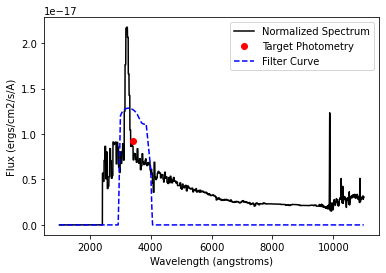

0

In [13]:
#spectrum B, U = 22.5 AB mag
spectrum.spectrum = spectrum_b

source_mag = 22.5
filter_channel = "u"
spectrum.normalize_spectrum(spectrum, magnitude=source_mag, filter_channel=filter_channel, check=True)



In [14]:
#normalized spectrum B
spectrum_b_norm = spectrum.spectrum

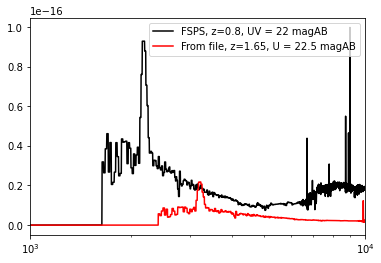

In [15]:
#compare
plt.figure()
plt.plot(spectrum_a_norm[0], spectrum_a_norm[1], 'k-', label='FSPS, z=0.8, UV = 22 magAB')
plt.plot(spectrum_b_norm[0], spectrum_b_norm[1], 'r-', label='From file, z=1.65, U = 22.5 magAB')
plt.xlim(1000, 10000)
plt.xscale('log')
plt.legend()



# 3 - Disperse the spectrum with the CASTOR grisms (UV or U)
# Source/spectrum "A"

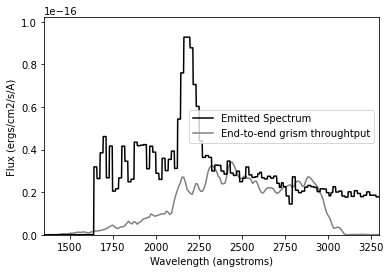

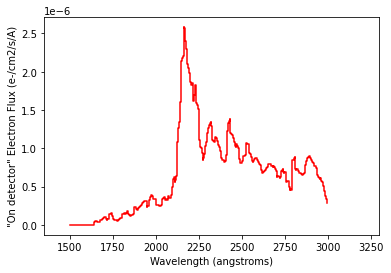

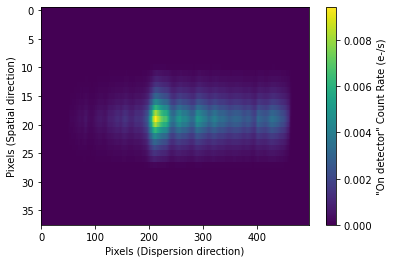

0

In [16]:
#The spectrum is dispersed pixel by pixel, only pixels within the source_disperse_region are dispersed.
source_spectrum = spectrum_a_norm
source_image = source_image_a
source_seg = source_seg_a
grism_channel = "uv" #disperse the spectrum with the uv-band grism.

#disperse
disperser.disperse(disperser, source_image=source_image, source_disperse_region=source_seg, 
                   source_spectrum=source_spectrum, grism_channel=grism_channel, check=True)

# 4 - Observe source for X seconds

In [17]:
#Create first the noiseless integrated grism spectrum.
exposure_time = 3600 #in seconds

disperser.expose(disperser, exposure_time=exposure_time)
#The 2D exposure (in counts [e-]), is in: 'disperser.integrated_grism_box_count'

grism_2d_uv_a = disperser.integrated_grism_box_count


Text(0, 0.5, 'Pixels (Spatial direction)')

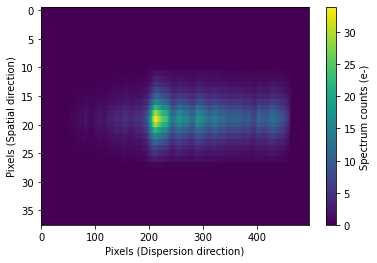

In [18]:
#Show noisless spectrum (in total counts)
#The noiseless data is in: disperser.integrated_grism_box_count
plt.imshow(grism_2d_uv_a, aspect="auto", interpolation="none")
plt.colorbar(label='Spectrum counts (e-)')
plt.xlabel('Pixels (Dispersion direction)')
plt.ylabel('Pixels (Spatial direction)')



# 5 - Generate the associated noise
## Sky background component 1:  Zodiacal 

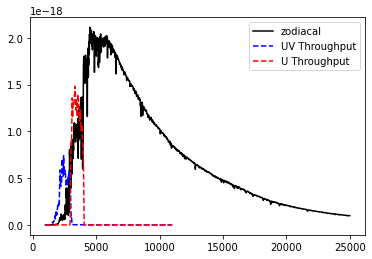

In [19]:
from astropy.io import fits, ascii
path_to_zodi = utils.ETC_GRISM_HOME+'/files/sky_background/zodi.fits'
spectrum_zodi = fits.open(path_to_zodi)
wave_zodi = spectrum_zodi[1].data['WAVELENGTH']
flux_zodi = spectrum_zodi[1].data['FLUX']

plt.figure()
plt.plot(wave_zodi, flux_zodi, 'k-', label='zodiacal')


#U/UV grism throughput 
grism_throughtput = ascii.read(utils.ETC_GRISM_HOME+'files/grism_files/castor_grism_efficiency_.uv.txt')
wave_transmission_uv = grism_throughtput['wavelength'] * 10 #in angtroms
filter_transmission_uv = 10**(grism_throughtput['lgrism_uv'])
plt.plot(wave_transmission_uv, filter_transmission_uv*plt.gca().get_ylim()[1], '--b', label='UV Throughput')

grism_throughtput = ascii.read(utils.ETC_GRISM_HOME+'files/grism_files/castor_grism_efficiency_.u.txt')
wave_transmission_u = grism_throughtput['wavelength'] * 10 #in angtroms
filter_transmission_u = 10**(grism_throughtput['lgrism_u'])
plt.plot(wave_transmission_u, filter_transmission_u*plt.gca().get_ylim()[1], '--r', label='U Throughput')

plt.legend()

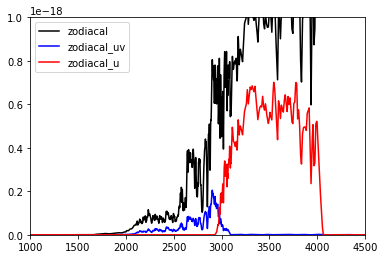

In [20]:
# scale by grism throughputs
wgrid = wave_zodi

gthput_uv = np.interp(wgrid, wave_transmission_uv, filter_transmission_uv)
gthput_u = np.interp(wgrid, wave_transmission_u, filter_transmission_u)

plt.figure()
plt.plot(wave_zodi, flux_zodi, 'k-', label='zodiacal')
plt.plot(wave_zodi, flux_zodi*gthput_uv, 'b-', label='zodiacal_uv')
plt.plot(wave_zodi, flux_zodi*gthput_u, 'r-', label='zodiacal_u')
plt.xlim(1000,4500)
plt.ylim(0,1e-18)
plt.legend()



## Sky background component 2:  Earthshine

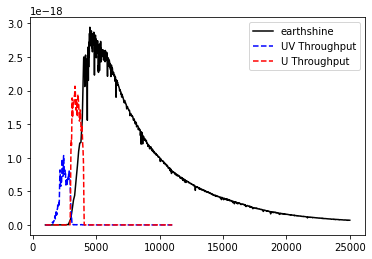

In [21]:
path_to_earthshine = utils.ETC_GRISM_HOME+'/files/sky_background/earthshine.fits'
spectrum_earthshine = fits.open(path_to_earthshine)
wave_es = spectrum_earthshine[1].data['WAVELENGTH']
flux_es = spectrum_earthshine[1].data['FLUX']

plt.figure()
plt.plot(wave_es, flux_es, 'k-', label='earthshine')

#filters
plt.plot(wave_transmission_uv, filter_transmission_uv*plt.gca().get_ylim()[1], '--b', label='UV Throughput')
plt.plot(wave_transmission_u, filter_transmission_u*plt.gca().get_ylim()[1], '--r', label='U Throughput')

plt.legend()


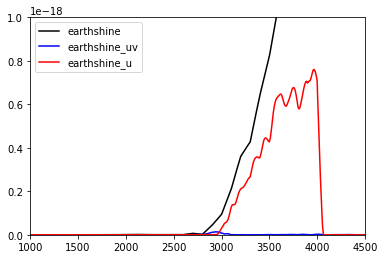

In [22]:
# scale by grism throughputs
plt.figure()
plt.plot(wave_es, flux_es, 'k-', label='earthshine')
plt.plot(wave_es, flux_es*gthput_uv, 'b-', label='earthshine_uv')
plt.plot(wave_es, flux_es*gthput_u, 'r-', label='earthshine_u')
plt.xlim(1000,4500)
plt.ylim(0,1e-18)
plt.legend()


## Sky background component 3:  Geocoronal lines

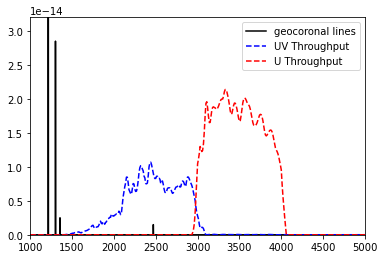

In [23]:
#Three intensities 'low', 'avg', 'high': https://hst-docs.stsci.edu/stisihb/chapter-6-exposure-time-calculations/6-6-tabular-sky-backgrounds
path_to_geo = utils.ETC_GRISM_HOME+'/files/sky_background/geo_avg.fits'
spectrum_geo = fits.open(path_to_geo)

wave_geo = spectrum_geo[1].data['WAVELENGTH']
flux_geo = spectrum_geo[1].data['FLUX']

plt.figure()
plt.plot(wave_geo, flux_geo, 'k-', label='geocoronal lines')
plt.xlim(1000,5000)
plt.ylim(0,3.2e-14)

#filters
plt.plot(wave_transmission_uv, filter_transmission_uv*plt.gca().get_ylim()[1], '--b', label='UV Throughput')
plt.plot(wave_transmission_u, filter_transmission_u*plt.gca().get_ylim()[1], '--r', label='U Throughput')

plt.legend()


## Total sky

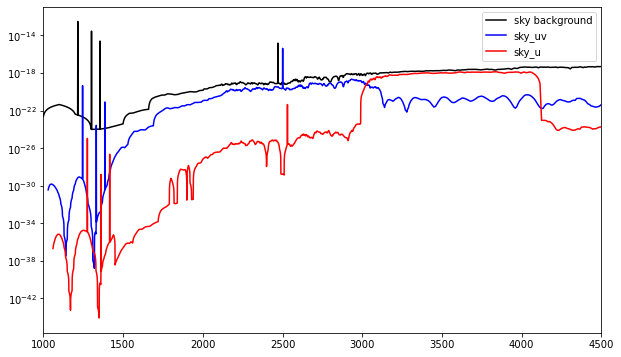

In [24]:
import spectres
geo_resamp = spectres.spectres(wave_zodi, wave_geo, flux_geo, spec_errs=None, fill=0, verbose=False)

sky_bckgd = flux_zodi + flux_es + geo_resamp


plt.figure(figsize=(10,6))
plt.plot(wave_zodi, sky_bckgd, 'k-', label='sky background')
plt.plot(wave_zodi+30, sky_bckgd*gthput_uv, 'b-', label='sky_uv')
plt.plot(wave_zodi+60, sky_bckgd*gthput_u, 'r-', label='sky_u')
plt.xlim(1000,4500)
plt.yscale('log')
plt.legend()



# Create the (count rate) sky background in one step

In [25]:
#The user can specify their own zodical, earthshine and geocoronal.
#By default this uses the zodical and earthshine also provided in the imaging ETC.
#Three simulated geocoronal spectrum are available by default depending on the line intensities ('high', 'avg', 'low'),
#with line intensities taken from https://hst-docs.stsci.edu/stisihb/chapter-6-exposure-time-calculations/6-6-tabular-sky-backgrounds
#To use your own background, 'user_zodi', 'user_earthshine', and 'user_geo' should be a path to the approriate files,
#in the same format and structure as the default ones; and 'default_sky' should be set to False.
background.recompute_sky_background(background, default_sky=True, geo_intensity='avg', user_zodi=None, user_earthshine=None, user_geo=None)



0

In [26]:
print("sky background [e-/s/pix]:", background.sky_background_countrate) #with 'avg' geocoronal: {'uv': 0.004671128308536505, 'u': 0.014181008896939849}. Without geocoronal: {'uv': 0.0005811746388609881, 'u': 0.01418100467547261}
print("dark current [e-/s/pix]:", background.dark_countrate) #0.0001
print("read noise [e-/pix]:", background.read_noise_count) #2
print("----")

#The user can also specify their own sky background, dark current, and read noise values
#by modifying the appropriate background objects (/!\ this overrides previous background values):
#eg:
# background.sky_background_countrate = {'uv': 0.0005811746388609881, 'u': 0.01418100467547261}
# background.dark_countrate = 1e-4
# background.read_noise_count = 2
# print("NEW sky background [e-/s/pix]:", background.sky_background_countrate)
# print("NEW dark current [e-/s/pix]:", background.dark_countrate)
# print("NEW read noise [e-/pix]:", background.read_noise_count)

sky background [e-/s/pix]: {'uv': 0.004671128308536505, 'u': 0.014181008896939849}
dark current [e-/s/pix]: 0.0001
read noise [e-/pix]: 2
----


# Get the total signal + sky + detector noise of the exposure (in the same filter as the noiseless grism spectrum)

In [27]:
#Get the total signal + sky + detector noise of the exposure (in the same filter as the noiseless grism spectrum)
Nreads = 1 #number of read-outs during total exposition.
disperser.total_noise(disperser, exposure_time=exposure_time, filter=grism_channel, Nreads=Nreads, Nbin=1)
#The 2D total noise is in: 'disperser.grism_noise_total'

grism_2d_uv_a_noise = disperser.grism_noise_total


Text(0, 0.5, 'Pixels (Spatial direction)')

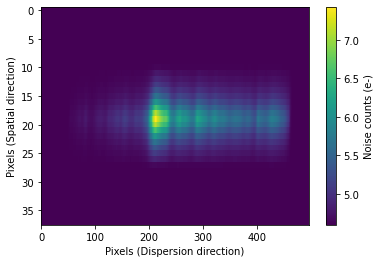

In [28]:
#Show signal+sky+detector noise (in total counts)
#The total signal+sky+detector noise is in disperser.grism_noise_total
plt.figure()
plt.imshow(grism_2d_uv_a_noise, aspect="auto", interpolation="none")
plt.colorbar(label='Noise counts (e-)')
plt.xlabel('Pixels (Dispersion direction)')
plt.ylabel('Pixels (Spatial direction)')



# 6 - SNR of the exposure

Text(0, 0.5, 'Pixels (Spatial direction)')

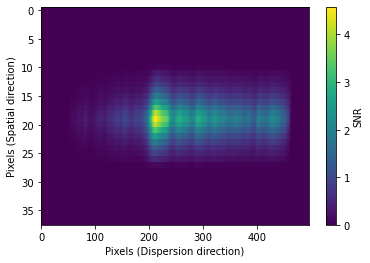

In [29]:
#SNR
snr_2d_uv_a = grism_2d_uv_a / grism_2d_uv_a_noise

#Show SNR per resolution element
plt.imshow(snr_2d_uv_a, aspect="auto", interpolation="none")
plt.colorbar(label='SNR')
plt.xlabel('Pixels (Dispersion direction)')
plt.ylabel('Pixels (Spatial direction)')



# What about the U grism?
## a. Disperse source spectrum

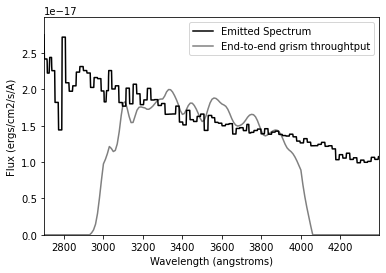

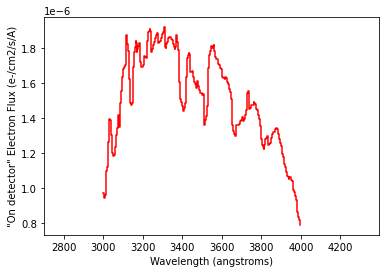

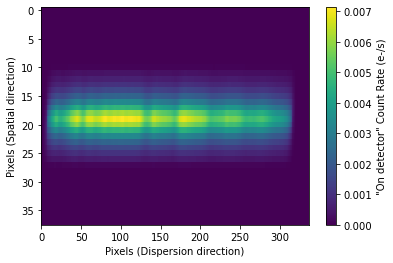

0

In [30]:
#The spectrum is dispersed pixel by pixel, only pixels within the source_disperse_region are dispersed.
grism_channel = "u" #disperse the spectrum with the u-band grism.
source_spectrum = spectrum_a_norm
source_image = source_image_a
source_seg = source_seg_a

#disperse
disperser.disperse(disperser, source_image=source_image, source_disperse_region=source_seg, 
                   source_spectrum=source_spectrum, grism_channel=grism_channel, check=True)


## b. Observe

In [31]:
#Create first the noiseless integrated grism spectrum.
exposure_time = 3600 #in seconds

disperser.expose(disperser, exposure_time=exposure_time)
#The 2D exposure (in counts [e-]), is in: 'disperser.integrated_grism_box_count'

grism_2d_u_a = disperser.integrated_grism_box_count



Text(0, 0.5, 'Pixels (Spatial direction)')

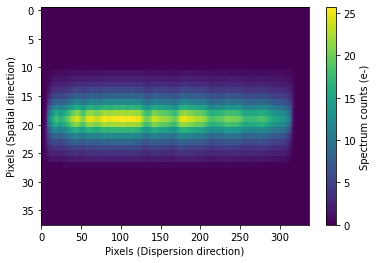

In [32]:
#Show noisless spectrum (in total counts)
#The noiseless data is in: disperser.integrated_grism_box_count
plt.imshow(grism_2d_u_a, aspect="auto", interpolation="none")
plt.colorbar(label='Spectrum counts (e-)')
plt.xlabel('Pixels (Dispersion direction)')
plt.ylabel('Pixels (Spatial direction)')



## c. Get total noise

In [33]:
#Get the total signal + sky + detector noise of the exposure (in the same filter as the noiseless grism spectrum)
Nreads = 1 #number of read-outs during total exposition.
disperser.total_noise(disperser, exposure_time=exposure_time, filter=grism_channel, Nreads=Nreads, Nbin=1)
#The 2D total noise is in: 'disperser.grism_noise_total'

grism_2d_u_a_noise = disperser.grism_noise_total



Text(0, 0.5, 'Pixels (Spatial direction)')

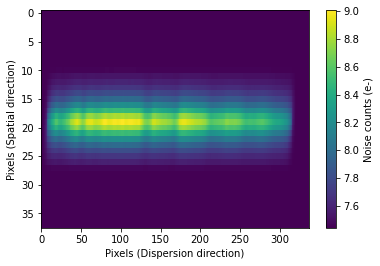

In [34]:
#Show signal+sky+detector noise (in total counts)
#The total signal+sky+detector noise is in disperser.grism_noise_total
plt.figure()
plt.imshow(grism_2d_u_a_noise, aspect="auto", interpolation="none")
plt.colorbar(label='Noise counts (e-)')
plt.xlabel('Pixels (Dispersion direction)')
plt.ylabel('Pixels (Spatial direction)')



## d. Get SNR

Text(0, 0.5, 'Pixels (Spatial direction)')

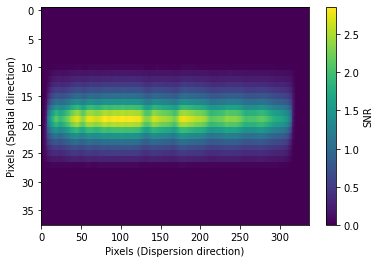

In [35]:
#SNR
snr_2d_u_a = grism_2d_u_a / grism_2d_u_a_noise

#Show SNR per resolution element
plt.imshow(snr_2d_u_a, aspect="auto", interpolation="none")
plt.colorbar(label='SNR')
plt.xlabel('Pixels (Dispersion direction)')
plt.ylabel('Pixels (Spatial direction)')




# What about source/spectrum "B"?

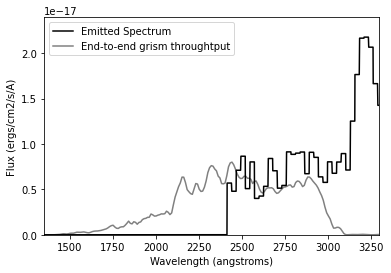

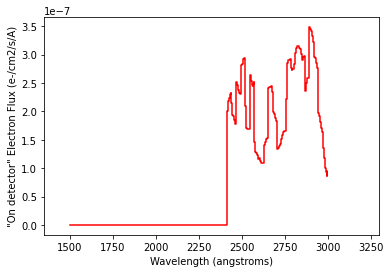

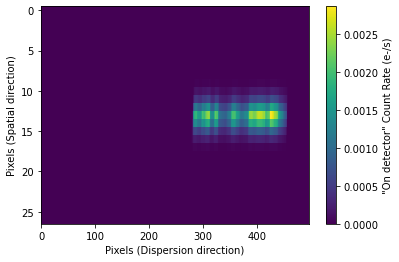

0

In [36]:
#Source B
source_spectrum = spectrum_b_norm
source_image = source_image_b
source_seg = source_seg_b

#Disperse with the "UV" channel
grism_channel = "uv" #disperse the spectrum with the u-band grism.

#disperse
disperser.disperse(disperser, source_image=source_image, source_disperse_region=source_seg, 
                   source_spectrum=source_spectrum, grism_channel=grism_channel, check=True)

In [37]:
#Observe for X seconds

#Create first the noiseless integrated grism spectrum.
exposure_time = 3600 #in seconds

disperser.expose(disperser, exposure_time=exposure_time)
#The 2D exposure (in counts [e-]), is in: 'disperser.integrated_grism_box_count'

grism_2d_uv_b = disperser.integrated_grism_box_count


In [38]:
#Get associated noise

#Get the total signal + sky + detector noise of the exposure (in the same filter as the noiseless grism spectrum)
Nreads = 1 #number of read-outs during total exposition.
disperser.total_noise(disperser, exposure_time=exposure_time, filter=grism_channel, Nreads=Nreads, Nbin=1)
#The 2D total noise is in: 'disperser.grism_noise_total'

grism_2d_uv_b_noise = disperser.grism_noise_total


In [39]:
# SNR
snr_2d_uv_b = grism_2d_uv_b / grism_2d_uv_b_noise


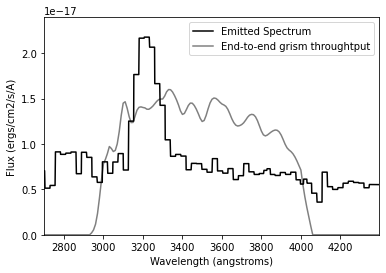

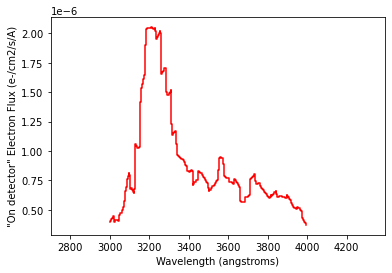

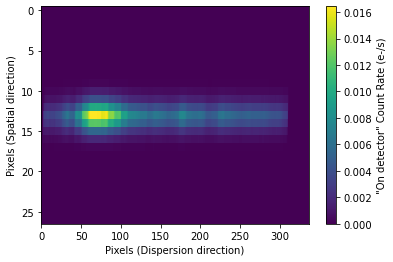

In [40]:
#Same for for the U channel

grism_channel = "u" #disperse the spectrum with the u-band grism.

#disperse
disperser.disperse(disperser, source_image=source_image, source_disperse_region=source_seg, 
                   source_spectrum=source_spectrum, grism_channel=grism_channel, check=True)

#observe
exposure_time = 3600 #in seconds
disperser.expose(disperser, exposure_time=exposure_time)
grism_2d_u_b = disperser.integrated_grism_box_count

#get noise
Nreads = 1 #number of read-outs during total exposition.
disperser.total_noise(disperser, exposure_time=exposure_time, filter=grism_channel, Nreads=Nreads, Nbin=1)
grism_2d_u_b_noise = disperser.grism_noise_total

# SNR
snr_2d_u_b = grism_2d_u_b / grism_2d_u_b_noise



Text(0, 0.5, 'Pixels (Spatial direction)')

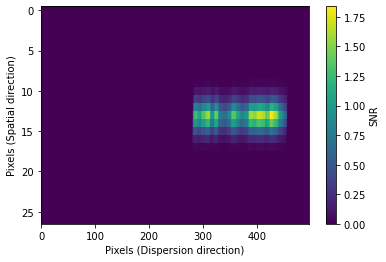

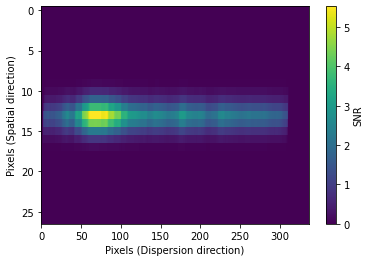

In [41]:
#Show SNR
plt.figure()
plt.imshow(snr_2d_uv_b, aspect="auto", interpolation="none")
plt.colorbar(label='SNR')
plt.xlabel('Pixels (Dispersion direction)')
plt.ylabel('Pixels (Spatial direction)')

plt.figure()
plt.imshow(snr_2d_u_b, aspect="auto", interpolation="none")
plt.colorbar(label='SNR')
plt.xlabel('Pixels (Dispersion direction)')
plt.ylabel('Pixels (Spatial direction)')


# Extract 1D spectrum and generate a 1D SNR

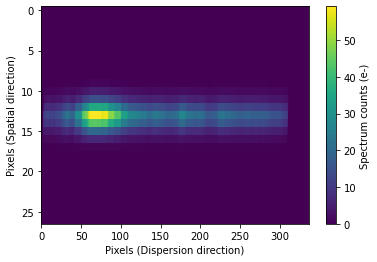

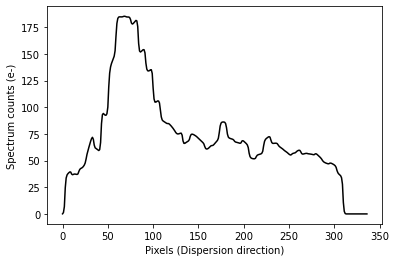

In [42]:
from ETC_grism_dev import fitting

source_image = source_image_b
grism_box = grism_2d_u_b
grism_box_noise = grism_2d_u_b_noise

# extract 1D grism data based on source image stamp size
grism_1d_u_b, grism_1d_u_b_x = fitting.extract_1d(source_image=source_image, grism_box=grism_box,
                                          is_noise=False, extraction_size=None, check=True)


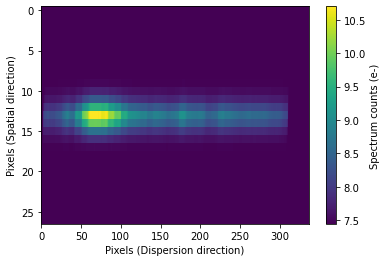

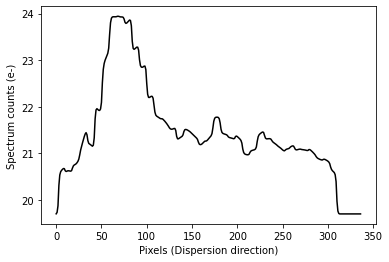

In [43]:
# extract 1D grism noise based on source image stamp size
grism_1d_u_b_noise, grism_1d_u_b_x_noise = fitting.extract_1d(source_image=source_image, grism_box=grism_box_noise,
                                                      is_noise=True, extraction_size=None, check=True)



In [44]:
# 1d snr
snr_1d_u_b = grism_1d_u_b / grism_1d_u_b_noise


Text(0.5, 0, 'pix')

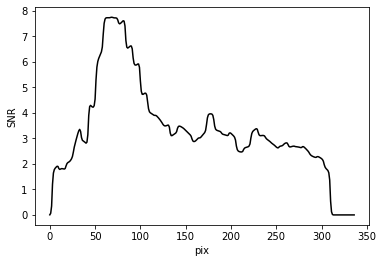

In [45]:
# Show
plt.figure()
plt.plot(grism_1d_u_b_x, snr_1d_u_b, 'k-')
plt.ylabel('SNR')
plt.xlabel('pix')


In [46]:
# Show 1D SNR as a function of wavelength

In [47]:
#sensitivity functions
from astropy.table import Table
sens_uv = Table.read(utils.ETC_GRISM_HOME+'files/grism_files/grism_sensitivity_uv.fits')
sens_u = Table.read(utils.ETC_GRISM_HOME+'files/grism_files/grism_sensitivity_u.fits')
sens_wave_uv = sens_uv['WAVELENGTH']
sens_wave_u = sens_u['WAVELENGTH']


Text(0.5, 0, 'wavelength')

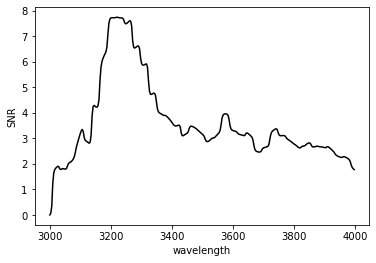

In [48]:
plt.figure()
plt.plot(sens_wave_u, snr_1d_u_b[:len(sens_wave_u)], 'k-')
plt.ylabel('SNR')
plt.xlabel('wavelength')


## User defined extraction size

In [49]:
r_extr_pix = 2 #in image pixels (can be, for instance, the source effective radius)
extraction_size = int(r_extr_pix*2) # in pixels

#data
grism_1d_u_b_2, grism_1d_u_b_x_2 = fitting.extract_1d(source_image=None, grism_box=grism_box,
                                          is_noise=False, extraction_size=extraction_size, check=False)

# noise
grism_1d_u_b_noise_2, grism_1d_u_b_x_noise_2 = fitting.extract_1d(source_image=None, grism_box=grism_box_noise,
                                          is_noise=True, extraction_size=extraction_size, check=False)

# 1d snr
snr_1d_u_b_2 = grism_1d_u_b_2 / grism_1d_u_b_noise_2


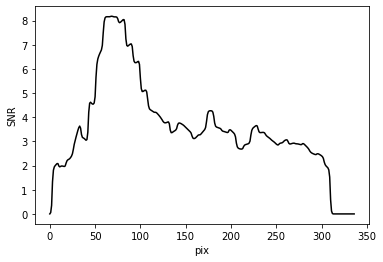

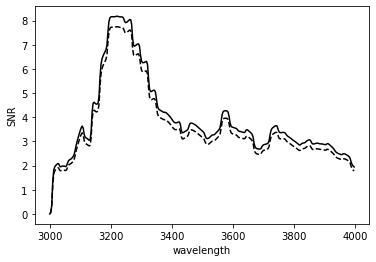

In [50]:
# Show
plt.figure()
plt.plot(grism_1d_u_b_x_2, snr_1d_u_b_2, 'k-')
plt.ylabel('SNR')
plt.xlabel('pix')

plt.figure()
plt.plot(sens_wave_u, snr_1d_u_b_2[:len(sens_wave_u)], 'k-')
plt.ylabel('SNR')
plt.xlabel('wavelength')
#compare with previous 1D extraction (based on direct image stamp)
plt.plot(sens_wave_u, snr_1d_u_b[:len(sens_wave_u)], 'k--')


# Goal 1 achieved!

# --------------------

# Goal 2: redshift-fitting!

# Let's fit the U-band grism of the "B" source/spectrum. Can we recover its redshift?

# 1 - Generate "realistic" (noisy) realizations/observations.

In [51]:
#data
grism_data_1d = grism_1d_u_b_2
grism_noise_1d = grism_1d_u_b_noise_2

#noisy realizations
nb_realizations = 50

grism_1d_u_b_noisy = fitting.noisy_realisation_samples(grism_data_1d, grism_noise_1d, nsamples=nb_realizations)



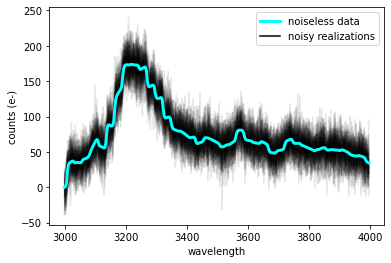

In [52]:
#Show
plt.figure()
[plt.plot(sens_wave_u, noisy[:len(sens_wave_u)], 'k-', alpha=0.1) for noisy in grism_1d_u_b_noisy]
plt.plot(sens_wave_u, grism_data_1d[:len(sens_wave_u)], '-', color='cyan', lw=3, label='noiseless data')
plt.plot(np.nan, np.nan, 'k-', label='noisy realizations')
plt.ylabel('counts (e-)')
plt.xlabel('wavelength')
plt.legend()


# 2 - Choose a (rest-frame) template to fit to the data

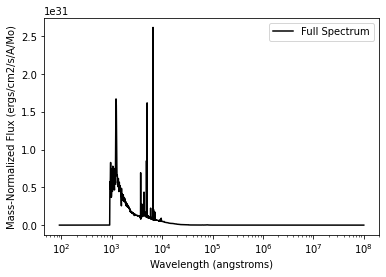

In [53]:
# Get a star-forming template from FSPS

source_redshift = 0 #rest-frame!
fsps_params_dict = {"tau": 1, "logzsol": 0, "dust2": 0.2}
fsps_age = 2 #Gyrs

spectrum.spectrum_from_fsps(spectrum, fsps_params_dict=fsps_params_dict, fsps_age=fsps_age, redshift=source_redshift, check=True)

#save template
template = spectrum.spectrum


(500.0, 3000.0)

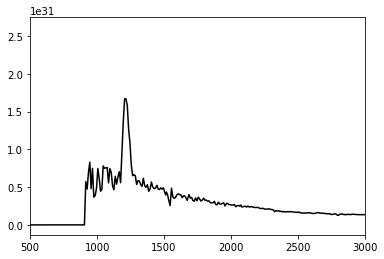

In [54]:
#Zoom-in
plt.plot(template[0], template[1], 'k-')
plt.xlim(500, 3000)

# 3 - Redshift fit
## First pass: Coarse Fitting.

In [55]:
z_range = [0.5, 3.0]
z_step = 0.04

#data, in count rate (e-/s)
funits = 'rate'
obs_spec = (sens_wave_u, grism_1d_u_b_noisy[0][:len(sens_wave_u)] / exposure_time)
obs_spec_err = (sens_wave_u, grism_noise_1d[:len(sens_wave_u)] / exposure_time)

#template (flam)
template_to_fit = template

#forward modelling based on source image
source_image = source_image_b
source_seg = source_seg_b
extr_size = extraction_size

#channel(s)
grism_channel_disperse = ["u"]

#fit
res_coarse = fitting.fit_z_range(obs_spec, obs_spec_err, template_to_fit, 
                                 source_image, source_seg, extr_size,
                                 z_range, z_step, grism_channel_disperse, 
                                 funits, check=False)

#res_coarse
z_array_coarse, chi2_z_range, chi2_reduced_z_range, log_likelihood_z_range_coarse, best_template, obs, obs_err, scaling_template, scale_obs = res_coarse


In [56]:
# likelihood peak (z_true = 1.65)
z_peak_coarse = z_array_coarse[log_likelihood_z_range_coarse == np.max(log_likelihood_z_range_coarse)]
z_peak_coarse

array([1.66])

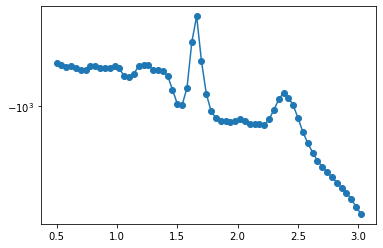

In [57]:
#Show log_likelihood
plt.plot(z_array_coarse, log_likelihood_z_range_coarse, 'o-')
plt.yscale('symlog')

# Second pass: Fine Fitting.

In [58]:
#redshift range, step
z_range_fine = [z_peak_coarse-0.05, z_peak_coarse+0.05]
z_step_fine = 0.001

#fit
res_fine = fitting.fit_z_range(obs_spec, obs_spec_err, template_to_fit, 
                                 source_image, source_seg, extr_size,
                                 z_range_fine, z_step_fine, grism_channel_disperse, 
                                 funits, check=False)

#res_fine
z_array, chi2_z_range, chi2_reduced_z_range, log_likelihood_z_range, best_template, obs, obs_err, scaling_template, scale_obs = res_fine



In [59]:
# likelihood peak (z_true = 1.65)
z_peak_fine = z_array[log_likelihood_z_range == np.max(log_likelihood_z_range)]
z_peak_fine


array([1.65])

(1.56, 1.76)

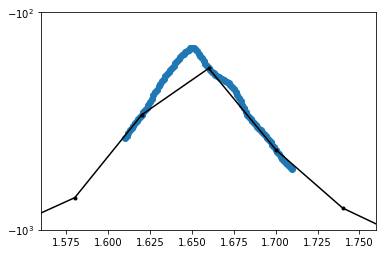

In [61]:
#Show log_likelihood
plt.plot(z_array, log_likelihood_z_range, 'o-')
plt.plot(z_array_coarse, log_likelihood_z_range_coarse, '.-k')
plt.yscale('symlog')
plt.ylim(-1000,-100)
plt.xlim(1.56, 1.76)

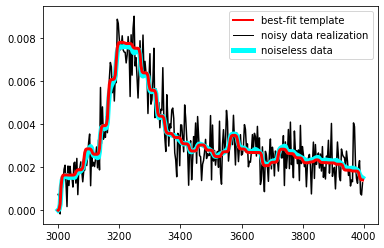

In [62]:
# Show fit
plt.plot(obs_spec[0], obs_spec[1]/np.nansum(obs_spec[1]), 'k-')
plt.plot(sens_wave_u, grism_data_1d[:len(sens_wave_u)] / np.nansum(grism_data_1d[:len(sens_wave_u)]), '-', color='cyan', lw=5)
plt.plot(best_template[0], best_template[1], 'r-', lw=3)
#plt.ylim(np.min(f_noiseless)-2*np.median(f_noiseless), np.max(f_noiseless)+4*np.median(f_noiseless))
plt.plot(np.nan, np.nan, 'r-', lw=2, label='best-fit template')
plt.plot(np.nan, np.nan, 'k-', lw=1, label='noisy data realization')
plt.plot(np.nan, np.nan, '-', color='cyan', lw=5, label='noiseless data')
plt.legend()



# How robust? - Loop over realizations

In [133]:
z_peak_fine = []
best_fit_templates = []
obs_s = []

for n_reali in range(50):
    stime = time.time()
    #pick realization
    obs_spec = (sens_wave_u, grism_1d_u_b_noisy[n_reali][:len(sens_wave_u)] / exposure_time)

    #coarse fit
    res_coarse = fitting.fit_z_range(obs_spec, obs_spec_err, template_to_fit, 
                                     source_image, source_seg, extr_size,
                                     z_range, z_step, grism_channel_disperse, 
                                     funits, check=False)

    #res_coarse
    z_array_coarse, chi2_z_range, chi2_reduced_z_range, log_likelihood_z_range_coarse, best_template, obs, obs_err, scaling_template, scale_obs = res_coarse

    #z_peak coarse
    z_peak_coarse = z_array_coarse[log_likelihood_z_range_coarse == np.max(log_likelihood_z_range_coarse)]

    
    #redshift range for fine fitting
    z_range_fine = [z_peak_coarse-0.05, z_peak_coarse+0.05]

    #fine fit
    res_fine = fitting.fit_z_range(obs_spec, obs_spec_err, template_to_fit, 
                                     source_image, source_seg, extr_size,
                                     z_range_fine, z_step_fine, grism_channel_disperse, 
                                     funits, check=False)

    #res_fine
    z_array, chi2_z_range, chi2_reduced_z_range, log_likelihood_z_range, best_template, obs, obs_err, scaling_template, scale_obs = res_fine

    #z_peak fine
    z_peak_fine.append(z_array[log_likelihood_z_range == np.max(log_likelihood_z_range)])
    print(n_reali+1, time.time()-stime)
    
    #best-fit templates
    best_fit_templates.append([best_template, scaling_template])
    obs_s.append([obs, obs_err, scale_obs])
    

1 17.901896953582764
2 17.541089057922363
3 17.767239093780518
4 17.659780979156494
5 17.50213885307312
6 17.697359085083008
7 17.76681900024414
8 17.74793314933777
9 17.852922916412354
10 17.142584085464478
11 17.080101013183594
12 17.05969214439392
13 17.132273197174072
14 17.124459981918335
15 17.131892919540405
16 17.116443157196045
17 17.309781074523926
18 16.991395950317383
19 16.968956232070923
20 17.01419711112976
21 17.183467149734497
22 17.032437086105347
23 17.0814471244812
24 17.11568307876587
25 17.127164125442505
26 17.130406856536865
27 17.174090147018433
28 17.121497869491577
29 17.154541015625
30 17.228604793548584
31 17.239147901535034
32 17.909993886947632
33 17.037373304367065
34 17.084278106689453
35 17.040158987045288
36 17.059267044067383
37 17.06018090248108
38 17.217889070510864
39 17.004868984222412
40 16.999150276184082
41 17.920536041259766
42 17.187512159347534
43 17.54845905303955
44 17.364974975585938
45 17.117839097976685
46 17.138298988342285
47 17.1303

(array([ 0.,  0.,  5.,  6., 24.,  9.,  4.,  2.,  0.,  0.]),
 array([1.645, 1.646, 1.647, 1.648, 1.649, 1.65 , 1.651, 1.652, 1.653,
        1.654, 1.655]),
 <BarContainer object of 10 artists>)

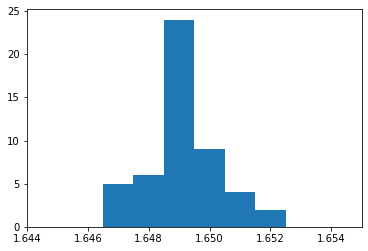

In [135]:
#z_peak_fine histogram
plt.hist(np.array(z_peak_fine), bins=np.arange(1.645, 1.656, 0.001), align='left')


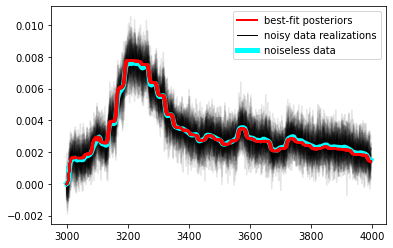

In [136]:
# Show best-fit templates
scale_noiseless = np.nansum(grism_data_1d[:len(sens_wave_u)])
f_noiseless = grism_data_1d[:len(sens_wave_u)] / scale_noiseless

[plt.plot(sens_wave_u, obsf, 'k-', alpha=0.1) for [obsf, obserr, obsscl] in obs_s]
plt.plot(sens_wave_u, f_noiseless, '-', color='cyan', lw=5)
[plt.plot(temp[0], temp[1], 'r-', alpha=0.5, lw=2) for [temp, tscl] in best_fit_templates]
#plt.ylim(np.min(f_noiseless)-2*np.median(f_noiseless), np.max(f_noiseless)+4*np.median(f_noiseless))
plt.plot(np.nan, np.nan, 'r-', lw=2, label='best-fit posteriors')
plt.plot(np.nan, np.nan, 'k-', lw=1, label='noisy data realizations')
plt.plot(np.nan, np.nan, '-', color='cyan', lw=5, label='noiseless data')
plt.legend()



# Goal 2 achieved!

# --------------------

# More about redshift recovery for Cosmic Web reconstruction with CASTOR during Ivana Damjanov's Talk (Thursday 9:20am)

# In development: Full Scene (Multi-Object) Simulation

# Create the direct image scene

In [22]:
#Create sources in scene
#Use a sersic profiles

#CASTOR telescope pixel scale in arcsec
pix_scale = 0.1 

#fov in pixels
fov_size = 100

#sources
x_positions = [10, 30, 60]
y_positions = [10, 30, 60]
sources_eff_radius_arcsec = np.array([3/7.5, 1.5/7.5, 4/7.5]) #arcsec
sources_eff_radius_pixels = sources_eff_radius_arcsec/pix_scale
sersic_indexes = [1, 1.5, 3]
ellipticities = [0.35, 0.5, 0.2]
seg_thresholds = [1e-2, 1e-2, 1e-3]

#scene grid
x,y = np.meshgrid(np.arange(fov_size), np.arange(fov_size))

#sersic models
sersic_models = [Sersic2D(amplitude = 1, r_eff = r_eff, n=n, x_0=x_pos, y_0=y_pos,
                    ellip=ellip, theta=-1) 
                    for r_eff, n, x_pos, y_pos, ellip 
                    in zip(sources_eff_radius_pixels, sersic_indexes, x_positions, y_positions, ellipticities)]
#images and seg maps
sources_img = [sersic_model(x, y) for sersic_model in sersic_models]
sources_seg = [(src_img/np.max(src_img) > segtresh) * k for src_img, segtresh, k in zip(sources_img, seg_thresholds, range(1,4))]

#add on grid/scene
scene_direct = np.nansum(sources_img, axis=0)
scene_seg = np.nansum(sources_seg, axis=0)


/var/folders/x4/732lcbsj15v9fwvrd_hmx_jr0000gn/T/ipykernel_34971/654451621.py:7: MatplotlibDeprecationWarning: 
The 'update_ticks' parameter of set_ticks() was deprecated in Matplotlib 3.5 and will be removed two minor releases later. If any parameter follows 'update_ticks', they should be passed as keyword, not positionally.
  cbar.set_ticks([-1, 0, 1], update_ticks=True)


Text(0, 0.5, 'y')

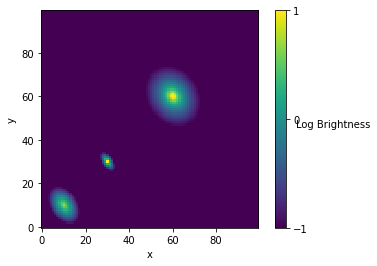

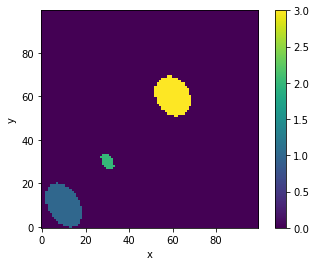

In [23]:
#direct image scene
plt.imshow(np.log10(scene_direct), origin='lower', interpolation='none', vmin=-1, vmax=1)
plt.xlabel('x')
plt.ylabel('y')
cbar = plt.colorbar()
cbar.set_label('Log Brightness', rotation=0, labelpad=25)
cbar.set_ticks([-1, 0, 1], update_ticks=True)

#segmentation map
plt.figure()
plt.imshow(scene_seg, origin='lower', interpolation='none')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')


# Generate the spectrum of each source

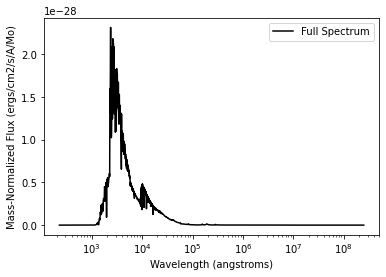

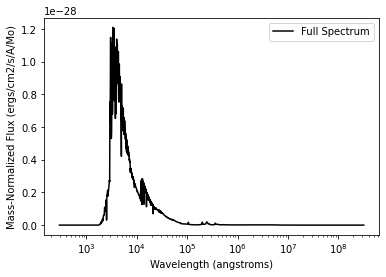

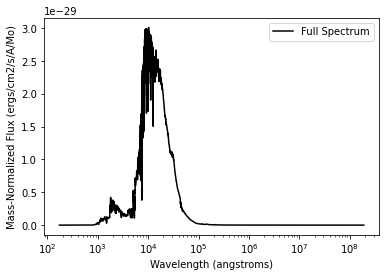

In [24]:
#Sources properties
sources_redshift = [1.5, 2.2, 0.9] #If a redshift other than 0 is provided, then spectrum is automatically redshifted.
fsps_params_dicts = [{"tau": 1, "logzsol": 0, "dust2": 0.2},
                     {"tau": 2, "logzsol": 0, "dust2": 0.4},
                     {"tau": 0.4, "logzsol": 0, "dust2": 0.1, "add_neb_emission": False}
                    ]
fsps_ages = [2, 1, 4] #Gyrs

#generate the (observed-frame) model spectra
spectra = []
for params, ages, z in zip(fsps_params_dicts, fsps_ages, sources_redshift):
    #generate spectrum
    spectrum.spectrum_from_fsps(spectrum, fsps_params_dict=params, fsps_age=ages, redshift=z, check=True)
    #save spectrum object
    spectra.append(spectrum.spectrum)


# Normalize the spectra

TARGET_FLAM, NON_NORM_FLAM, SCALING:  1.4694654524859772e-17 1.3355049931852694e-28 110030697001.07994
NORM_FLAM, NORM_FNU, NORM_MAG:  1.4694654524859772e-17 5.754399373371591 21.999999999999993
TARGET_FLAM, TARGET_FNU, TARGET_MAG:  1.4694654524859772e-17 5.75439937337159 22


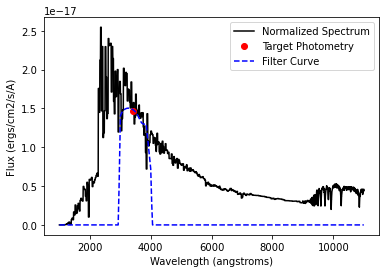

TARGET_FLAM, NON_NORM_FLAM, SCALING:  3.69113033167163e-18 9.312515139483008e-29 39636234426.31575
NORM_FLAM, NORM_FNU, NORM_MAG:  3.6911303316716306e-18 1.4454397707459403 23.499999999999993
TARGET_FLAM, TARGET_FNU, TARGET_MAG:  3.69113033167163e-18 1.4454397707459399 23.5


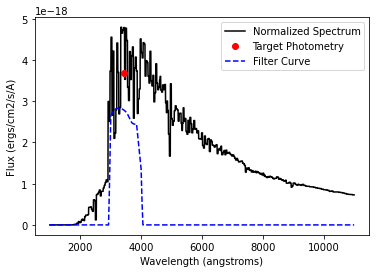

TARGET_FLAM, NON_NORM_FLAM, SCALING:  1.4694654524859772e-17 1.5739230592341905e-30 9336323296520.998
NORM_FLAM, NORM_FNU, NORM_MAG:  1.4694654524859772e-17 5.754399373371591 21.999999999999993
TARGET_FLAM, TARGET_FNU, TARGET_MAG:  1.4694654524859772e-17 5.75439937337159 22


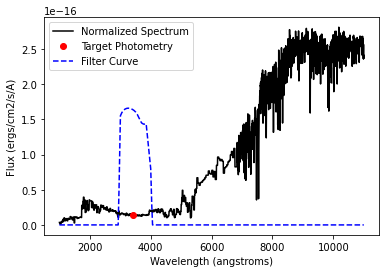

In [25]:
sources_mag = [22, 23.5, 22]
filter_channel = "u"

spectra_norm = []
for src_spec, mag in zip(spectra, sources_mag):
    #grab spectrum
    spectrum.spectrum = src_spec
    #normalize spectrum
    spectrum.normalize_spectrum(spectrum, magnitude=mag, filter_channel=filter_channel, check=True)
    #save
    spectra_norm.append(spectrum.spectrum)
    

# Disperse and observe the grism scene

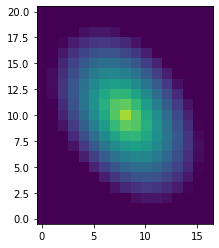

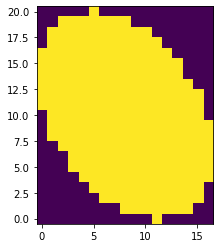

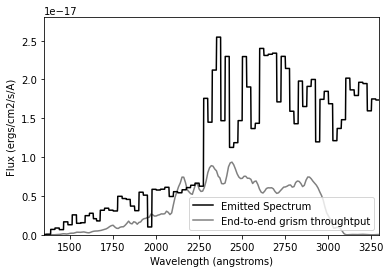

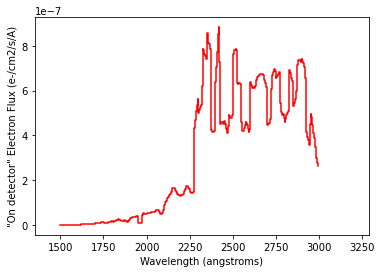

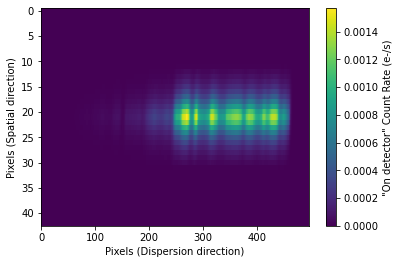

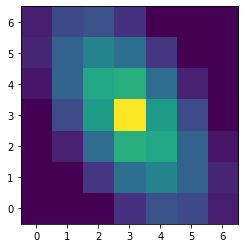

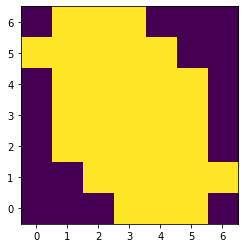

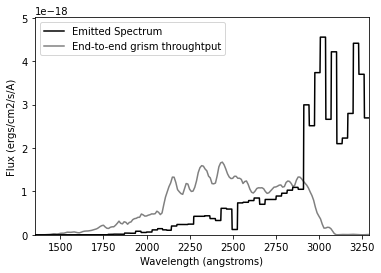

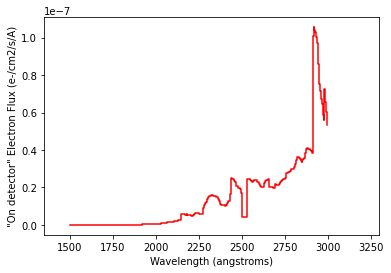

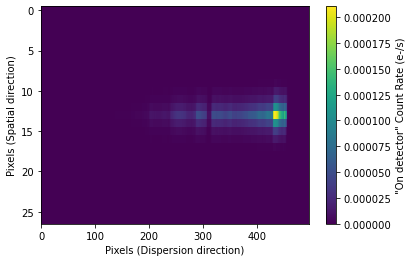

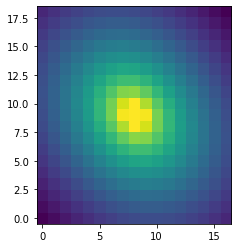

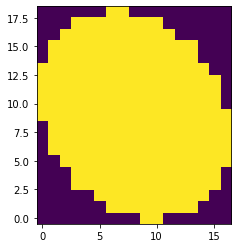

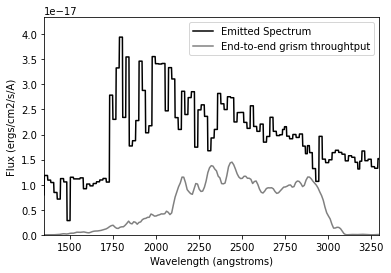

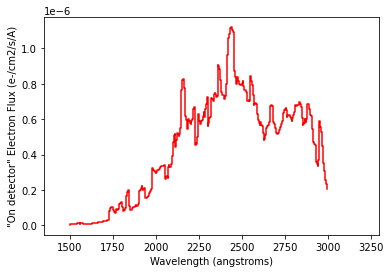

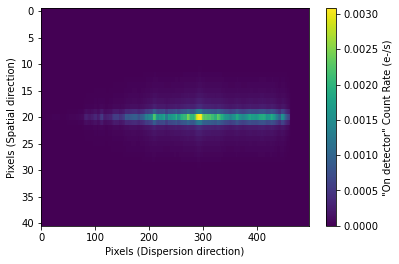

In [26]:
#scene properties
spectra = spectra_norm
scene_direct = scene_direct
scene_seg = scene_seg

#Disperse/Observe with the "UV" channel
grism_channel = "uv" #disperse the spectrum with the u-band grism.

#Exposure_time
exposure_time = 3600 #seconds

#disperse and observe scene
disperser.observe_scene(disperser, scene_direct=scene_direct, scene_seg=scene_seg, 
                   spectra=spectra, grism_channel=grism_channel, exposure_time=exposure_time, check=True)

#save
grism_scene_uv = disperser.grism_scene


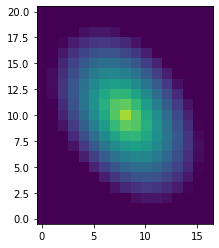

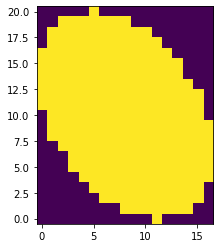

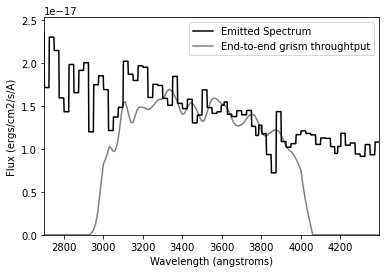

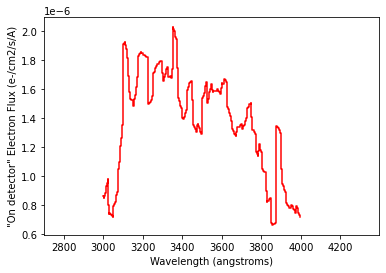

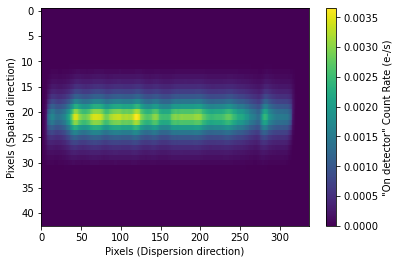

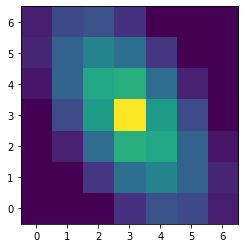

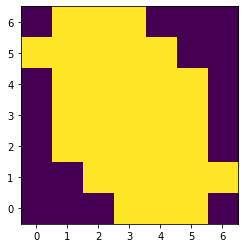

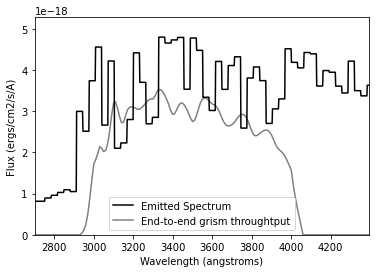

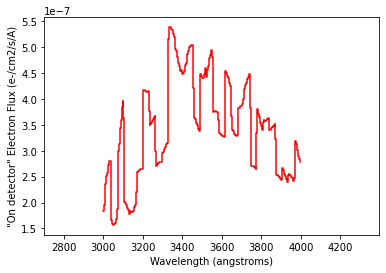

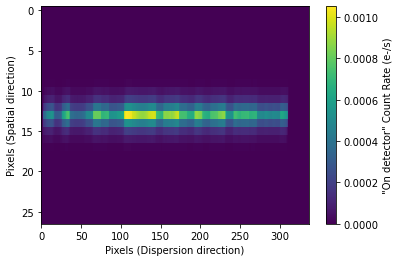

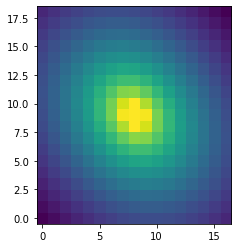

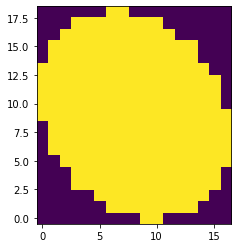

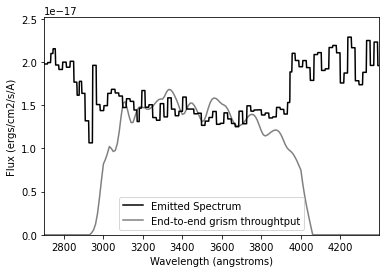

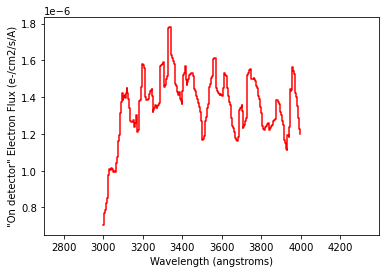

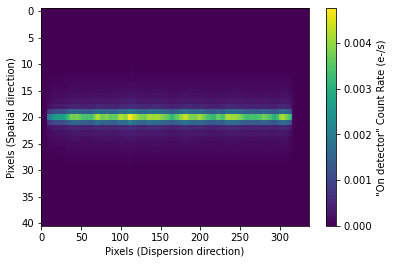

In [27]:
#Disperse/Observe with the "U" channel
grism_channel = "u" #disperse the spectrum with the u-band grism.

#disperse and observe scene
disperser.observe_scene(disperser, scene_direct=scene_direct, scene_seg=scene_seg, 
                   spectra=spectra, grism_channel=grism_channel, exposure_time=exposure_time, check=True)

#save
grism_scene_u = disperser.grism_scene


Text(0.5, 1.0, 'U grism scene')

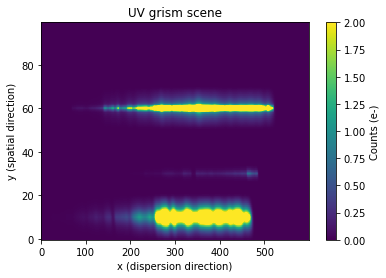

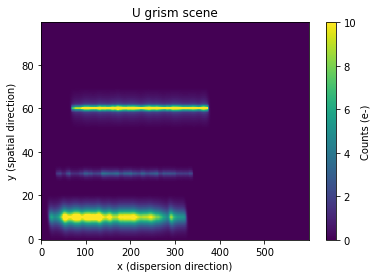

In [28]:
#Show grism scene
plt.figure()
plt.imshow(grism_scene_uv[:100], origin="lower", aspect="auto", vmin=0, vmax=2)
plt.colorbar(label='Counts (e-)')
plt.xlabel('x (dispersion direction)')
plt.ylabel('y (spatial direction)')
plt.title("UV grism scene")

plt.figure()
plt.imshow(grism_scene_u[:100], origin="lower", aspect="auto", vmin=0, vmax=10)
plt.colorbar(label='Counts (e-)')
plt.xlabel('x (dispersion direction)')
plt.ylabel('y (spatial direction)')
plt.title("U grism scene")


# DONE! :)